## Stardist benchmark

In [2]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
import math

## Make a super simple fake dataset

It only has 2 objects, object 1 with diameter of 6, object 2 with diameter of 140

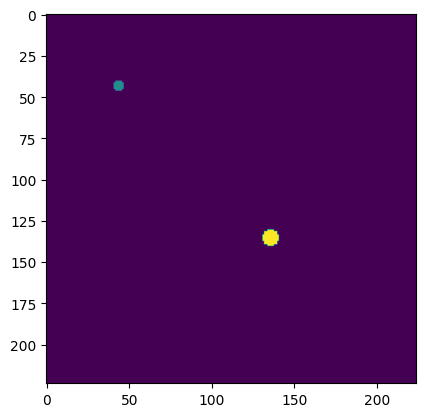

In [3]:
width, height = 224, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

x, y = 44, 44
r = 3 
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, temp, x, y, mode='replace_non_zero')

x, y = 136, 136
r = 5 
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, 2*temp, x, y, mode='replace_non_zero')

plt.imshow(truth)

## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [4]:
X = [image.copy().astype('float32')[..., np.newaxis] for i in range(10)]
Y = [truth.copy().astype('uint16') for i in range(10)]

## Make a custom model

In [5]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

n_channel_in = 1
n_rays = 32
axes = 'YX'
config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (224,224), unet_n_depth=3)

model_path = './erase_me'

model = StarDist2D(config=config, name="model1", basedir=model_path)


base_model.py (198): output path for model already exists, files may be overwritten: C:\Users\bnort\work\ImageJ2022\tnia\tnia-python\notebooks\imagesc\2024_06_24_stardist_benchmark\erase_me\model1


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [6]:
import stardist
import tensorflow as tf
print (stardist.__version__)
print (tf.__version__)


model.train(X, Y, validation_data=(X,Y),epochs=5) 

0.8.5
2.10.1
Epoch 1/5
100/100 [==============================] - 16s 86ms/step - loss: 0.5076 - prob_loss: 0.0779 - dist_loss: 2.1484 - prob_kld: 0.0764 - dist_relevant_mae: 2.1482 - dist_relevant_mse: 7.9629 - dist_dist_iou_metric: 0.3664 - val_loss: 0.3243 - val_prob_loss: 0.0095 - val_dist_loss: 1.5739 - val_prob_kld: 0.0082 - val_dist_relevant_mae: 1.5736 - val_dist_relevant_mse: 3.9912 - val_dist_dist_iou_metric: 0.4703 - lr: 3.0000e-04
Epoch 2/5
100/100 [==============================] - 7s 70ms/step - loss: 0.1773 - prob_loss: 0.0077 - dist_loss: 0.8476 - prob_kld: 0.0065 - dist_relevant_mae: 0.8468 - dist_relevant_mse: 1.6382 - dist_dist_iou_metric: 0.6854 - val_loss: 0.0850 - val_prob_loss: 0.0038 - val_dist_loss: 0.4059 - val_prob_kld: 0.0026 - val_dist_relevant_mae: 0.4049 - val_dist_relevant_mse: 0.3478 - val_dist_dist_iou_metric: 0.8435 - lr: 3.0000e-04
Epoch 3/5
100/100 [==============================] - 7s 70ms/step - loss: 0.0711 - prob_loss: 0.0022 - dist_loss: 0.3444